In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
# from tqdm import

In [2]:
connectivity_min, connectivity_max = 0.1,65
random_input_span = (1.2,2.8)
# random_input_span = (9.5,13.5)
total_time = 100
alpha = 20
alpha_folder = 'alpha_' + str(alpha)

current_models = ['IF','Rotational']
neuron_model = current_models[0]

model_folder_name = neuron_model+'_ensembles'

# Capture related ensembles

In [3]:
def list_folders_in_path(path):
    return [ name for name in os.listdir( path ) if os.path.isdir( os.path.join(path, name) ) ]

In [4]:
num_neurons = 10000
target_networks_name = 'N{}_T{}_I{}_{}'.format(num_neurons,total_time,random_input_span[0],random_input_span[1])
target_path = os.path.join(model_folder_name,target_networks_name)
all_g_folders = list_folders_in_path(target_path)
desired_g_folders = all_g_folders

# delay_folder_name = 'd_{}'.format(delay)

In [5]:
sigma_glossary_dict = {}
amin_saman_param_glossary_dict = {}
field_period_glossary_dict = {}

In [6]:
for g_folder in desired_g_folders:
    available_d_folders = list_folders_in_path(os.path.join(target_path,g_folder))

    g = float( g_folder.split('_')[1] ) #folder names are g_# d_#
    
    sigma_glossary_dict[g] = {}
    amin_saman_param_glossary_dict[g] = {}
    field_period_glossary_dict[g] = {}
    
    for d_folder in available_d_folders:
        delay = float( d_folder.split('_')[1] ) #folder names are d_#
        
        g_d_alpha_path = os.path.join(target_path, g_folder, d_folder, alpha_folder)

        try:
            g_ensembles_list = list_folders_in_path(g_d_alpha_path)
            
            sigma_glossary_dict[g].update( {delay:[]} )
            amin_saman_param_glossary_dict[g].update( {delay:[]} )
            field_period_glossary_dict[g].update( {delay:[]} )
        except: #if the given connectivity and delay has not been measured even once
            continue

        for ensemble_num in g_ensembles_list:
            ensemble_path = os.path.join(g_d_alpha_path, ensemble_num)
            with open( os.path.join(ensemble_path,'sigma.txt') ) as file:
                sigma = float( file.readline() )
                sigma_glossary_dict[g][delay].append( sigma )

            with open( os.path.join(ensemble_path,'field_period.txt') ) as file:
                field_period = float( file.readline() )
                field_period_glossary_dict[g][delay].append( field_period )                

            if neuron_model == 'Rotational': #if not does not exist
                with open( os.path.join(ensemble_path,'amin_saman_param.txt') ) as file:
                    amin_saman_param = float( file.readline() )        
                    amin_saman_param_glossary_dict[g][delay].append( amin_saman_param )        


        sigma_glossary_dict[g][delay] = np.mean(sigma_glossary_dict[g][delay])
        field_period_glossary_dict[g][delay] = np.mean(field_period_glossary_dict[g][delay])
        if neuron_model == 'Rotational':amin_saman_param_glossary_dict[g][delay] = np.mean(amin_saman_param_glossary_dict[g][delay])


# Sigma dataframe

In [7]:
sigma_table = pd.DataFrame.from_dict(sigma_glossary_dict)
sigma_table.index.name = 'delay'
sigma_table.columns.name = 'connectivity'
sigma_table

connectivity,0.10,0.35,0.60,0.85,1.10,1.35,1.60,1.85,2.10,2.35,2.60,2.85,3.10,3.35,3.60,3.85,4.10,4.35,4.60,4.85
delay,,,,,,,,,,,,,,,,,,,,
0.05,0.129721,0.085114,0.071428,0.080889,0.090895,0.098676,0.103321,0.107209,0.112904,0.115255,0.116580,0.120218,0.119108,0.124687,0.121404,0.125303,0.125469,0.127638,0.126101,0.128285
0.07,0.131386,0.090617,0.080304,0.106811,0.127905,0.141445,0.148045,0.160735,0.162253,0.169250,0.170928,0.171643,0.177529,0.175450,0.177659,0.179744,0.182704,0.195383,0.189119,0.190680
0.09,0.134377,0.094292,0.089261,0.136559,0.174064,0.190076,0.201184,0.207449,0.207783,0.213877,0.220928,0.220270,0.230193,0.226624,0.228093,0.224691,0.224439,0.226095,0.227447,0.234721
0.11,0.137249,0.097560,0.095497,0.165308,0.224630,0.241710,0.259025,0.268041,0.269677,0.264785,0.261772,0.263213,0.261349,0.263757,0.266050,0.257804,0.257066,0.259497,0.261277,0.254610
0.13,0.138003,0.103161,0.108792,0.181028,0.233592,0.275317,0.283598,0.287807,0.292454,0.292616,0.293566,0.286142,0.296101,0.292102,0.298433,0.297722,0.302072,0.289116,0.302397,0.323289
0.15,0.139320,0.104659,0.127005,0.249422,0.321273,0.350104,0.377157,0.393376,0.389882,0.385375,0.396882,0.389141,0.394876,0.385068,0.384976,0.374797,0.386949,0.381778,0.379620,0.375049
0.17,0.141078,0.103272,0.124078,0.252632,0.329503,0.381983,0.387411,0.411563,0.422210,0.390116,0.408968,0.416445,0.419476,0.419006,0.400666,0.377508,0.390285,0.376502,0.373940,0.327833
0.19,0.141784,0.105429,0.121803,0.240576,0.317804,0.366876,0.380604,0.374395,0.392276,0.394600,0.411654,0.393027,0.403335,0.397327,0.372627,0.381233,0.381577,0.361807,0.358326,0.361751
0.21,0.144185,0.109053,0.126426,0.230837,0.340445,0.367707,0.403954,0.397484,0.396362,0.386842,0.403151,0.409711,0.410440,0.407479,0.381398,0.389865,0.395430,0.379993,0.373128,0.366881


Text(0.5, 1, 'Sigma as an Order parameter')

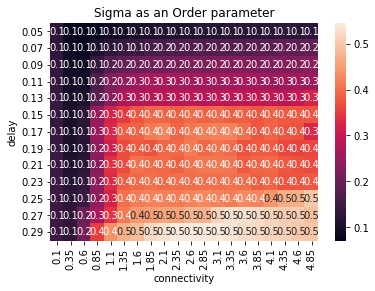

In [20]:
ax_sigma = sns.heatmap(sigma_table, annot=True, fmt = '.1f')
ax_sigma.set_title('Sigma as an Order parameter')

# Field period dataframe

In [9]:
field_period_table = pd.DataFrame.from_dict(field_period_glossary_dict)
field_period_table.index.name = 'delay'
field_period_table.columns.name = 'connectivity'
field_period_table

connectivity,0.10,0.35,0.60,0.85,1.10,1.35,1.60,1.85,2.10,2.35,2.60,2.85,3.10,3.35,3.60,3.85,4.10,4.35,4.60,4.85
delay,,,,,,,,,,,,,,,,,,,,
0.05,0.480769,0.110011,0.350297,0.104603,0.108533,0.114679,0.119981,0.122315,0.129135,0.136343,0.138987,0.214083,0.147711,0.152093,0.224653,0.157905,0.161952,0.167786,0.171235,0.171383
0.07,0.500801,0.410326,0.147181,0.153022,0.151176,0.155643,0.163271,0.168791,0.184807,0.191327,0.187092,0.195504,0.207360,0.215774,0.221654,0.232832,0.243310,0.496281,0.250006,0.256086
0.09,0.536243,0.235113,0.183843,0.187298,0.193424,0.201007,0.206612,0.216687,0.223718,0.232569,0.239524,0.248448,0.257759,0.261782,0.299597,0.442196,0.320020,0.308011,0.329497,0.346025
0.11,0.234742,0.470663,0.220755,0.229629,0.234762,0.246311,0.257071,0.265959,0.278208,0.284100,0.296830,0.304881,0.314493,0.324689,0.336135,0.343062,0.348432,0.361242,0.378073,0.384621
0.13,0.234742,0.420420,0.262160,0.267738,0.279747,0.288601,0.294996,0.312610,0.318980,0.331184,0.341301,0.349041,0.365642,0.378084,0.388386,0.401613,0.478480,0.427358,0.435748,0.510417
0.15,0.239808,0.465839,0.311530,0.313483,0.331683,0.347827,0.550129,0.575455,0.401613,0.619835,0.653123,0.680790,0.274387,0.483103,0.737721,0.762729,0.785383,0.759188,0.693179,0.558677
0.17,0.239808,0.481043,0.346025,0.351495,0.357147,0.370375,0.294504,0.614754,0.574301,0.441607,0.466203,0.398979,0.498756,0.510217,0.792273,0.537883,0.695996,0.844425,0.574884,0.581710
0.19,0.250000,0.395257,0.389105,0.390631,0.400160,0.416667,0.422835,0.451746,0.460839,0.475062,0.498756,0.512874,0.792273,0.830349,0.557315,0.597063,0.609960,0.611764,0.635696,0.654294
0.21,0.250000,0.421279,0.429216,0.434815,0.445702,0.682856,0.479619,0.497562,0.512874,0.522197,0.558659,0.581395,0.598802,0.621214,0.631072,0.490760,0.662281,1.015812,0.696873,1.077360


Text(0.5, 1, 'Field period time')

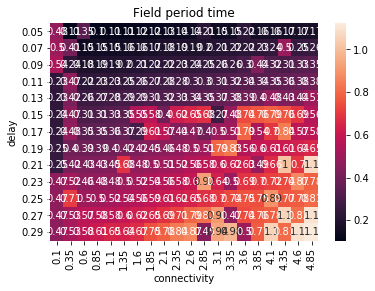

In [22]:
ax_field_period = sns.heatmap(field_period_table, annot=True)
ax_field_period.set_title('Field period time')

# Amin Saman Parameter

In [23]:
if neuron_model == 'Rotational':
    amin_saman_param_table = pd.DataFrame.from_dict(amin_saman_param_glossary_dict)
    amin_saman_param_table.index.name = 'delay'
    amin_saman_param_table.columns.name = 'connectivity'
    ax_field_period = sns.heatmap(amin_saman_param_table)
    ax_field_period.set_title('AminSaman as an Order parameter ')